# Višeklasna klasifikacija

Ukoliko je broj klasa u zadatku klasifikacije veći od dva govorimo o višeklasnoj klasifikaciji (engl. multiclass classification). Za nju važe ista pravila pripreme podataka, kreiranja modela i evaluacije koja smo uveli u priči o binarnoj klasifikaciji. Binarni algoritmi klasifikacije se mogu uvek prilagoditi ovom viešklasnom scenariju kroz omotače `OneVsAll` i `OneVsOne` biblioteke `scikit-learn`, a neki od njih i kroz specifični parametar `multi_class`.  

Pretpostavimo da treba da naučimo da razlikujemo n=3 klasa. Obeležimo ih redom sa C1, C2 i C3.

`OneVsAll` (ili `oneVsRest`) pristup podrazumva učenje n binarnih klasifikatora koji mogu da razlikuju jednu uočenu klasu od preostalih klasa. Na primer, potrebno je naučiti klasifikator koji razdvaja klasu C1 od klasa C2 i C3, zatim klasifikator koji razdvaja klasu C2 od klasa C1 i C3, i na kraju, klasifikator koji razdvaja klase C3 od klasa C1 i C2. Kada je potrebno klasifikovati novu instancu, pokreće se svaki od naučenih klasifikatora i nad dobijenim rezultatima se primenjuje princip najveće pouzdanosti: instanca se pridružuje klasi za koju je klasifikator najsigurniji.

<img src='assets/OneVsRest.png'>

`OneVsOne` pristup podrazumeva učenje $\frac{n(n-1)}{2}$ binarnih klasifikatora sposobnih da razlikuju po dve klase. U našem primer, potrebno je naučiti binarne klasifikatore koji razdvajaju klase C1 i C2, C2 i C3, kao i C1 i C3. Kada je potrebno klasifikovati novu instancu, pokreće se svaki od naučenih klasifikatora i nad dobijenim rezultatima se primenjuje princip većinskog glasanja: instanca se pridružuje klasi za koju najveći broj klasifikatora glasa.

<img src='assets/OneVsOne.jpg'>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn import datasets
from sklearn import svm
from sklearn import multiclass
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
np.random.seed(7)

## Primer 1.

Ovaj primer približava rad sa višeklasnim klasifikatorima i omotačima `OneVsRest` i `OneVsOne`. 

Koristićemo sintetički generisane podatke generisane metodom `make_classification`. Generisaćemo 500 instaci sa po 2 atributa. Broj klasa koji ćemo posmatrati je 3. 

In [4]:
X, y = datasets.make_classification(n_samples=500, n_classes=3, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=20)

In [5]:
class_colors = ['orange', 'red', 'blue']

In [6]:
colors = [class_colors[c] for c in y]

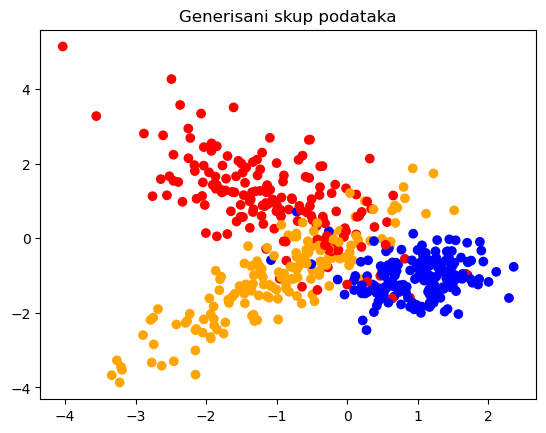

In [7]:
plt.title('Generisani skup podataka')
plt.scatter(X[:, 0],X[:, 1], color=colors)
plt.show()

Podelimo podatke na skup za treniranje i skup za testiranje.

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, stratify=y)

Za kreiranje OneVsRest klasifikatora u čijoj osnovi je linarni SVC možemo koristiti metodu `multiclass.OneVsRestClassifier`. Slično važi i za OneVsOne klasifikator i `multiclass.OneVsOneClassifier` metodu. 

In [9]:
ovr_classifier = multiclass.OneVsRestClassifier(svm.LinearSVC())
ovo_classifier = multiclass.OneVsOneClassifier(svm.LinearSVC())

Dalje, treniramo modele.

In [10]:
ovr_classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=LinearSVC())

In [11]:
ovo_classifier.fit(X_train, y_train)

OneVsOneClassifier(estimator=LinearSVC())

Na kraju evaluiramo modele.

In [12]:
y_predicted_ovr = ovr_classifier.predict(X_test)

In [13]:
print(metrics.classification_report(y_test, y_predicted_ovr))

              precision    recall  f1-score   support

           0       0.90      0.65      0.75        54
           1       0.74      0.91      0.81        55
           2       0.95      0.98      0.96        56

    accuracy                           0.85       165
   macro avg       0.86      0.85      0.84       165
weighted avg       0.86      0.85      0.84       165



In [14]:
y_predicted_ovo = ovo_classifier.predict(X_test)

In [15]:
print(metrics.classification_report(y_test, y_predicted_ovo))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83        54
           1       0.85      0.84      0.84        55
           2       0.95      0.95      0.95        56

    accuracy                           0.87       165
   macro avg       0.87      0.87      0.87       165
weighted avg       0.87      0.87      0.87       165



Za evaluaciju modela korišćenjem tačnosti, preciznosti, odziva ili F1-mere mogu se koristiti funkcije `metrics` paketa uz dodatak parametra `avarage`. Njime se utiče na način izračunavanja metrika i dozvoljene su vrednosti `micro`, `macro` ili `weighted`. Na primer,  ukoliko se navede vrednost `micro`, vrednosti metrika se računaju globalno sumirajući sve TP, TN, FP i FP vrednosti pojedinačnih klasifikatora. Ukoliko se navede vrednost `macro` vrednosti metirka se izračunavaju pojedinačno za svaki klasifikator, a kao finalna ocena se uzima njihova aritmetička sredina. 

In [16]:
metrics.f1_score(y_test, y_predicted_ovo, average='macro')

0.872051114023591

## Primer 2.

Ovaj primer obrađuje problem identifikacije (prepoznavanja) jezika nekog teksta. Ova funkcionalnost je često integrisana u aplikacijama koje svakodnevno susrećemo. Na primer, prilikom pretraživanja informacija potrebno je odrediti jezik upita, a prilikom predlaganja korekcija u tekstu, jezik dokumenta. U primeru ćemo koristiti fragmente teksta preuzete sa Vikipedije i podršku `scikit-learn` biblioteke za njihovu dalju obradu. Klasifikator `linearni SVM` ćemo ovog puta videti u ulozi višeklasnog klasifikatora. 

Za prevlačenje fragmenata teksta sa Vikipedije koristićemo skipt `fetch_data.py` koji je preuzet sa [zvanične strane](https://github.com/scikit-learn/scikit-learn/blob/master/doc/tutorial/text_analytics/data/languages/fetch_data.py) biblioteke `scikit-learn`. Njime će se u radnom direktorijumu kreirati tri direktorijuma, `html`, `paragraphs` i `short_paragraphs` sa tekstovima razvrstanim po jezicima (ukupno njih 11). Mi ćemo u daljem radu koristiti samo `paragraphs` direktorijum. 

Prevlačimo paragrafe.

In [17]:
!python scripts/fetch_data.py

/home/ognjen/matf/ml/2024.2025/materijali-sa-vezbi-2025/04-nebalansirani-skupovi-viseklansa-klasifikiacija/scripts/fetch_data.py:66: FutureWarning: This search incorrectly ignores the root element, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/p'
  for p in tree.findall('//p'):
Writing paragraphs/ar/ar_0000.txt
Writing short_paragraphs/ar/ar_0000.txt
Writing short_paragraphs/ar/ar_0001.txt
Writing short_paragraphs/ar/ar_0002.txt
Writing short_paragraphs/ar/ar_0003.txt
Writing short_paragraphs/ar/ar_0004.txt
Writing short_paragraphs/ar/ar_0005.txt
Writing short_paragraphs/ar/ar_0006.txt
Writing short_paragraphs/ar/ar_0007.txt
Writing short_paragraphs/ar/ar_0008.txt
Writing short_paragraphs/ar/ar_0009.txt
Writing short_paragraphs/ar/ar_0010.txt
Writing paragraphs/ar/ar_0001.txt
Writing short_paragraphs/ar/ar_0011.txt
Writing short_paragraphs/ar/ar_0012.txt
Writing short_paragraphs/ar/ar_0013.txt
Writing short_paragraphs/ar/ar_0014.txt
Writ

In [18]:
languages_folder = 'paragraphs'

Za učitavanje skupa podataka iskoristićemo `load_files` metodu `sklearn.datasets` paketa. Ova metoda pretpostavlja organizaciju datoteka u direktorijume čija imena odgovaraju klasama kojima pripadaju. U našem slučaju to su imena jezika.

In [19]:
dataset = datasets.load_files(languages_folder)

Analizirajmo ciljnu promenljivu.

In [20]:
dataset.target_names

['ar', 'de', 'en', 'es', 'fr', 'it', 'ja', 'nl', 'pl', 'pt', 'ru']

In [21]:
number_of_classes = len(dataset.target_names)
number_of_classes

11

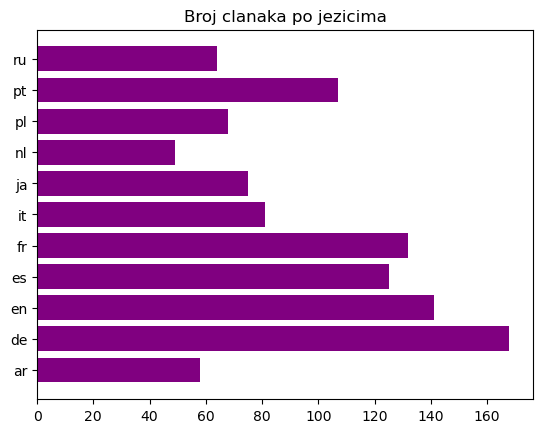

In [22]:
plt.title('Broj clanaka po jezicima')
plt.barh(np.arange(0, number_of_classes), np.bincount(dataset.target), color='purple')
plt.yticks(np.arange(0, number_of_classes), dataset.target_names)
plt.show()

Analizirajmo dalje skup tekstova (paragrafa) sa kojima ćemo raditi.

In [23]:
data = dataset.data

In [24]:
type(data)

list

In [25]:
len(data)

1068

Možemo prikazati i nasumični paragraf. 

In [26]:
data[3]

b'\xe7\xa7\xbb\xe8\xbb\xa2\xe5\x85\x88\xe3\x82\x92\xe3\x82\xab\xe3\x83\xaa\xe3\x83\x95\xe3\x82\xa9\xe3\x83\xab\xe3\x83\x8b\xe3\x82\xa2\xe5\xb7\x9e\xe3\x82\xb5\xe3\x83\xb3\xe3\x83\x95\xe3\x83\xa9\xe3\x83\xb3\xe3\x82\xb7\xe3\x82\xb9\xe3\x82\xb3\xe3\x81\xab\xe6\xb1\xba\xe5\xae\x9a\xe3\x81\x97\xe3\x81\x9f\xe7\x90\x86\xe7\x94\xb1\xe3\x81\xa8\xe3\x81\x97\xe3\x81\xa6\xe3\x80\x81\xe3\x80\x8c\xe3\x82\xa6\xe3\x82\xa3\xe3\x82\xad\xe3\x83\xa1\xe3\x83\x87\xe3\x82\xa3\xe3\x82\xa2\xe8\xb2\xa1\xe5\x9b\xa3\xe3\x80\x8d\xe3\x81\xae\xe3\x83\xaa\xe3\x83\xaa\xe3\x83\xbc\xe3\x82\xb9[58] \xe3\x81\xa7\xe3\x81\xaf\xe3\x80\x8c\xe3\x82\xb5\xe3\x83\xb3\xe3\x83\x95\xe3\x83\xa9\xe3\x83\xb3\xe3\x82\xb7\xe3\x82\xb9\xe3\x82\xb3\xe3\x81\xaf\xe7\x89\xb9\xe3\x81\xab\xe3\x82\xa2\xe3\x82\xb8\xe3\x82\xa2\xe3\x81\xab\xe8\xbf\x91\xe3\x81\x8f\xe3\x80\x81\xe3\x80\x8c\xe3\x82\xa6\xe3\x82\xa3\xe3\x82\xad\xe3\x83\xa1\xe3\x83\x87\xe3\x82\xa3\xe3\x82\xa2\xe8\xb2\xa1\xe5\x9b\xa3\xe3\x80\x8d\xe3\x81\x8c\xe3\x82\xa2\xe3\x82\xb8\xe3\x82\

Podelimo podatke na skup za treniranje i skup za testiranje. 

In [27]:
data_train, data_test, y_train, y_test = model_selection.train_test_split(dataset.data, dataset.target, test_size=0.33, stratify=dataset.target)

U zadatku prepoznavanja jezika su se dobro pokazali **n-grami karaktera** tj. sekvence nekoliko uzastopnih karaktera. Na primer, svi unigrami (1-grami) reči "abcde" su "a", "b", "c", "d", "e", svi bigrami (2-grami) iste reči su "ab", "bc", "cd", "de", dok su svi 3-grami "abc", "bcd", "cde".  Njih možemo lako generisati korišćenjem funkcija za ekstrakciju tekstualnih atributa biblioteke `scikit-learn`.

Kreirajmo vektorizator u kome ćemo naglasiti da ćemo koristiti unigrame, bigrame i trigrame karaktera (parametri `ngram_range` i `analyzer`). Takođe, naglasimo da nećemo koristiti inverznu frekvenciju dokumenata prilikom izračunavanja vrednosti već da ćemo se osloniti samo na frekvencije pojavljivanja.

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='char', use_idf=False, min_df=5)

In [29]:
vectorizer.fit(data_train)

TfidfVectorizer(analyzer='char', min_df=5, ngram_range=(1, 3), use_idf=False)

Možemo pregledati prisutne n-grame.

In [30]:
feature_names = vectorizer.get_feature_names_out()

In [31]:
len(feature_names)

10662

In [32]:
feature_names[3000:3020]

array(['ept', 'epu', 'eq', 'equ', 'er', 'er ', 'er)', 'er,', 'er-', 'er.',
       'era', 'erb', 'erc', 'erd', 'ere', 'erf', 'erg', 'erh', 'eri',
       'erk'], dtype=object)

Transformišemo tekstove koji se nalaze u skupovima za treniranje i testiranje tako da imaju odgovarajuće n-gramske profile. 

In [33]:
X_train = vectorizer.transform(data_train)
X_test = vectorizer.transform(data_test)

In [34]:
X_train.shape

(715, 10662)

In [35]:
X_test.shape

(353, 10662)

Dalje, kreirajmo model.

Klasifikator koji ćemo koristiti je linearni SVM. Ukoliko se navede parametar `multi_class` naglašava se da ga treba koristiti kao višeklasni klasifikator. Vrednost `ovr` se odnosi na `OneVsRest` ponašanje, dok `OneVsOne` nije direktno podržano.

In [36]:
svm_classifier = svm.LinearSVC(multi_class='ovr', loss='hinge')

In [37]:
svm_classifier.fit(X_train, y_train)

LinearSVC(loss='hinge')

Evaluirajmo model i prikažimo klasifikacioni izveštaj i matricu konfuzije.

In [38]:
y_predicted = svm_classifier.predict(X_test)

In [39]:
print(metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.98      0.99        56
           2       1.00      1.00      1.00        47
           3       1.00      1.00      1.00        41
           4       1.00      1.00      1.00        44
           5       1.00      1.00      1.00        27
           6       1.00      1.00      1.00        25
           7       1.00      1.00      1.00        16
           8       0.96      1.00      0.98        22
           9       1.00      1.00      1.00        35
          10       1.00      1.00      1.00        21

    accuracy                           1.00       353
   macro avg       1.00      1.00      1.00       353
weighted avg       1.00      1.00      1.00       353



In [40]:
print(metrics.confusion_matrix(y_test, y_predicted))

[[19  0  0  0  0  0  0  0  0  0  0]
 [ 0 55  0  0  0  0  0  0  1  0  0]
 [ 0  0 47  0  0  0  0  0  0  0  0]
 [ 0  0  0 41  0  0  0  0  0  0  0]
 [ 0  0  0  0 44  0  0  0  0  0  0]
 [ 0  0  0  0  0 27  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0  0]
 [ 0  0  0  0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0  0  0  0 35  0]
 [ 0  0  0  0  0  0  0  0  0  0 21]]


Uverimo se i praktično u performanse modela tako što ćemo zadati nekoliko paragrafa-rečenica i očitati njihove jezike.  

In [41]:
test_sentences = [
    'This is a language detection test.',
    'Ceci est un test de d\xe9tection de la langue.',
    'Dies ist ein Test, um die Sprache zu erkennen.',
]

In [42]:
language_codes = svm_classifier.predict(vectorizer.transform(test_sentences))
language_codes

array([2, 4, 1])

In [43]:
language_names = np.array(dataset.target_names)[language_codes]
language_names

array(['en', 'fr', 'de'], dtype='<U2')

In [44]:
for test_sentence, language_name in zip(test_sentences, language_names):
    print(test_sentence, ' --> ', language_name)

This is a language detection test.  -->  en
Ceci est un test de détection de la langue.  -->  fr
Dies ist ein Test, um die Sprache zu erkennen.  -->  de
